# Ejemplo de uso de ART en pytorch

*Este ejemplo está basado en https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py* 

Guía de instalación y documentación: https://github.com/Trusted-AI/adversarial-robustness-toolbox

## Importaciones

In [1]:
# Basic importations
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ART Importations
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10

/home/jamontanac/miniconda3/envs/torchNN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Datos

El detalle de la función `load_cifar10`:

```python
def load_cifar10(
    raw: bool = False,
) -> DATASET_TYPE:
    """
    Loads CIFAR10 dataset from config.CIFAR10_PATH or downloads it if necessary.

    :param raw: `True` if no preprocessing should be applied to the data. Otherwise, data is normalized to 1.
    :return: `(x_train, y_train), (x_test, y_test), min, max`
    """

    def load_batch(fpath: str) -> Tuple[np.ndarray, np.ndarray]:
        """
        Utility function for loading CIFAR batches, as written in Keras.

        :param fpath: Full path to the batch file.
        :return: `(data, labels)`
        """
        with open(fpath, "rb") as file_:
            if sys.version_info < (3,):
                content = six.moves.cPickle.load(file_)
            else:
                content = six.moves.cPickle.load(file_, encoding="bytes")
                content_decoded = {}
                for key, value in content.items():
                    content_decoded[key.decode("utf8")] = value
                content = content_decoded
        data = content["data"]
        labels = content["labels"]

        data = data.reshape(data.shape[0], 3, 32, 32)
        return data, labels

    path = get_file(
        "cifar-10-batches-py",
        extract=True,
        path=config.ART_DATA_PATH,
        url="https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
    )

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype=np.uint8)
    y_train = np.zeros((num_train_samples,), dtype=np.uint8)

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    # Set channels last
    x_train = x_train.transpose((0, 2, 3, 1))
    x_test = x_test.transpose((0, 2, 3, 1))

    min_, max_ = 0.0, 255.0
    if not raw:
        min_, max_ = 0.0, 1.0
        x_train, y_train = preprocess(x_train, y_train, clip_values=(0, 255))
        x_test, y_test = preprocess(x_test, y_test, clip_values=(0, 255))

    return (x_train, y_train), (x_test, y_test), min_, max_
```

donde la función `get_file` se encarga de descargar el conjunto de datos a partir un link. (ver [documentación](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/art/utils.py))

Algunas consideraciones importantes respecto al uso de esta función:
* Hay un número determinado de imágenes para entrenamiento: 50000, lo que corresponde a un split de 83%-17%.
* Por defecto, las imágenes son preprocesadas (normalizadas) usando la función `preprocess`:

```python
def preprocess(
    x: np.ndarray,
    y: np.ndarray,
    nb_classes: int = 10,
    clip_values: Optional["CLIP_VALUES_TYPE"] = None,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Scales `x` to [0, 1] and converts `y` to class categorical confidences.

    :param x: Data instances.
    :param y: Labels.
    :param nb_classes: Number of classes in dataset.
    :param clip_values: Original data range allowed value for features, either one respective scalar or one value per
           feature.
    :return: Rescaled values of `x`, `y`.
    """
    if clip_values is None:
        min_, max_ = np.amin(x), np.amax(x)
    else:
        min_, max_ = clip_values

    normalized_x = (x - min_) / (max_ - min_)
    categorical_y = to_categorical(y, nb_classes)

    return normalized_x, categorical_y
```

donde `to_categorical` convierte un vector de labels, en una matriz de clasificación binaria.

### Carga y configuración de datos

#### Con `raw = True`

In [2]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10(raw = True)

In [3]:
y_train

array([6, 9, 9, ..., 9, 1, 1], dtype=uint8)

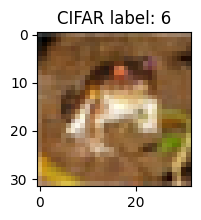

In [4]:
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(x_train[0])
ax.set_title(f"CIFAR label: {y_train[0]}")
plt.show()

#### Con `raw = True`

In [5]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()

In [6]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

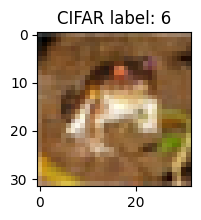

In [7]:
fig, ax = plt.subplots(figsize=(2,2))
ax.imshow(x_train[0])
ax.set_title(f"CIFAR label: {list(y_train[0]).index(1)}")
plt.show()

Por configuración de pytorch, se cambia el formato de los tensores con las imágenes. Pasamos de NHWC de numpy a NCHW de pytorch, donde

* **N**: Cantidad de datos
* **C**: Canales de color
* **H**: Alto de la imagen
* **W**: Ancho de la imagen

*Para mayor información https://discuss.pytorch.org/t/why-does-pytorch-prefer-using-nchw/83637*

In [8]:
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

## Entrenamiento del Modelo

Para poder generar los ejemplos adversariales, es necesario tener un modelo entrenado, en este caso, una red neuronal convolucional.

Primero definimos la arquitectura de la red, considerando el formato de las imágenes y la cantidad de labels:

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Segundo, instanciamos el modelo, definimos la función de pérdida y el optimizador:

In [10]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Tercero, armamos el clasificador usando la clase `PyTorchClassifier` (ver [documentación](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/art/estimators/classification/pytorch.py#L53))

In [11]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

Cuarto, entrenamos y evaluamos el clasificador:

In [12]:
%%time
classifier.fit(x_train, y_train, batch_size=32, nb_epochs=20)
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 50.17%
CPU times: user 42.1 s, sys: 471 ms, total: 42.6 s
Wall time: 39.1 s


## Generando los ataques

Una vez entrenado el modelo, usamos el método `FastGradientMethod` para poder generar los ejemplos adversariales. En este caso se usa el método `FastGradientMethod`, sólo a modo de ejemplo. (Ver [documentación](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/art/attacks/evasion/fast_gradient.py#L50C16-L50C16))

In [28]:
attack = FastGradientMethod(estimator=classifier, eps=0.01)
x_test_adv = attack.generate(x=x_test)

In [34]:
dir(attack)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_apply_perturbation',
 '_batch_id',
 '_check_compatibility_input_and_eps',
 '_check_params',
 '_compute',
 '_compute_perturbation',
 '_estimator',
 '_estimator_requirements',
 '_get_mask',
 '_i_max_iter',
 '_minimal_perturbation',
 '_project',
 '_summary_writer',
 '_summary_writer_arg',
 '_targeted',
 'attack_params',
 'batch_size',
 'eps',
 'eps_step',
 'estimator',
 'estimator_requirements',
 'generate',
 'is_estimator_valid',
 'minimal',
 'norm',
 'num_random_init',
 'set_params',
 'summary_writer',
 'targeted']

### Visualizando los ataques

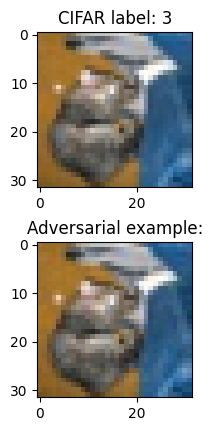

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(2,5))
ax[0].imshow(x_test[0].T)
ax[0].set_title(f"CIFAR label: {list(y_test[0]).index(1)}")
ax[1].imshow(x_test_adv[0].T)
ax[1].set_title("Adversarial example:")
plt.show()

Evaluamos el clasificador con los ejemplos adversariales:

In [15]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 19.06%
